In [ ]:
import os
import torch
import numpy as np
from src.nerf_dataset import load_nerf_data, create_dataloader
from src.models import NeRFModelRenderer, NaiveNeRFModel
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
img_size = 200 # for fast training. 

In [4]:
# Load the dataset
obj_name = "chair"
path = os.environ["DATASET_PATH"]
data_path = os.path.join(os.path.join(path, f"nerf_synthetic"),f"{obj_name}")
batch_size = 1024

train_rays_o, train_rays_d, train_pixels, pose, (w, h, f) = load_nerf_data(data_path, "train", obj_name, (img_size, img_size))
test_rays_o, test_rays_d, test_pixels, test_pose, _ = load_nerf_data(data_path, "test", obj_name, (img_size, img_size))

data_loader = create_dataloader(train_rays_o, train_rays_d, train_pixels, batch_size=batch_size, shuffle=True)

In [6]:
from tqdm.notebook import tqdm

@torch.no_grad()
def batchify_rays(model, batch_size, ray_o:torch.Tensor, ray_d:torch.Tensor):
    return torch.cat([model(ray_o[i:i+batch_size], ray_d[i:i+batch_size]).cpu().detach() for i in range(0, ray_o.shape[0], batch_size)], dim=0)


# train code
def train_nerf_model(model, data_loader, losses:list, optimizer, scheduler, n_epochs, tn:float, tf:float, n_bins:int, test_ray_o, test_ray_d, plot_img:np.ndarray, device):
    model.to(device)
    renderer = NeRFModelRenderer(model).to(device)
    for epoch in (range(n_epochs)):
        model.to(device)
        model.train()
        batch_losses = []
        for batch in tqdm(data_loader):
            o = batch[..., 0].to(device)
            d = batch[..., 1].to(device)
            target = batch[..., 2].to(device)
            prediction = renderer(o, d, tn, tf, n_bins, device)

            # MSE
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        scheduler.step()
        loss = np.mean(batch_losses)
        losses.append(loss)


        print(f"Epoch ({epoch+1}/{n_epochs}) - loss : {loss}")
        # plot the test ones
        with torch.no_grad():
            out = batchify_rays(lambda ray_o, ray_d: renderer(ray_o, ray_d, tn, tf, n_bins, device), 4096, test_ray_o, test_ray_d)
        ax = plt.subplot(121)
        ax.axis('off')
        ax.imshow(out.cpu().numpy().reshape(h, w, 3))
        ax = plt.subplot(122)
        ax.axis('off')
        ax.imshow(plot_img)
        plt.show()
        
        # save point
        torch.save(model.cpu(), f'./data/nerf_{epoch}.pt')

In [11]:
# distance is 4. [ 2.~6. ]
tn = 2.
tf = 6.
n_bins = 128
n_epochs = 60
lr = 1e-4
losses = []

In [12]:
model = NaiveNeRFModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(30, n_epochs, 30).tolist(), gamma=0.5)

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (1/60) - loss : 0.013042472220019521


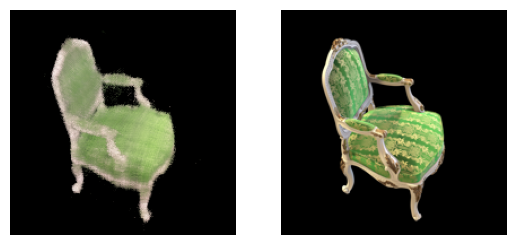

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (2/60) - loss : 0.00398231153784018


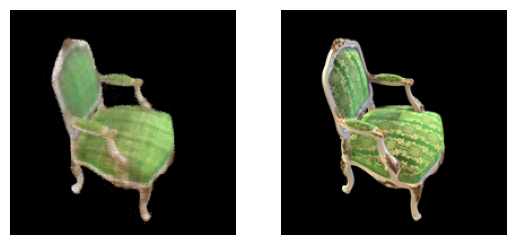

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (3/60) - loss : 0.0029284448808286506


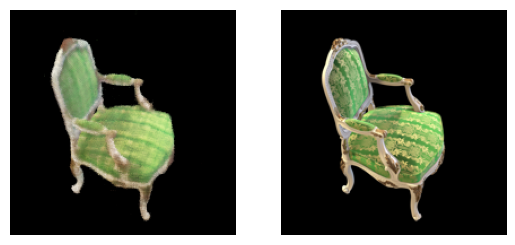

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (4/60) - loss : 0.0023425568852479236


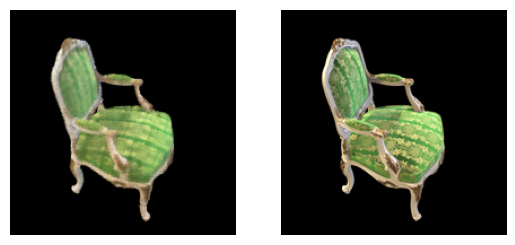

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (5/60) - loss : 0.0019221323513126014


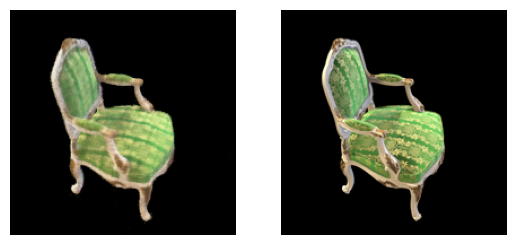

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (6/60) - loss : 0.001655095707970672


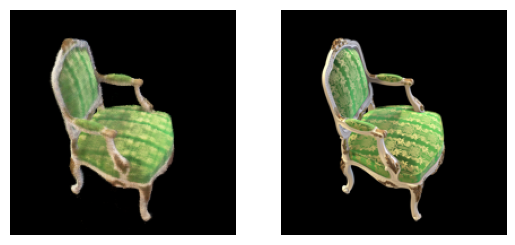

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (7/60) - loss : 0.0014703043937853066


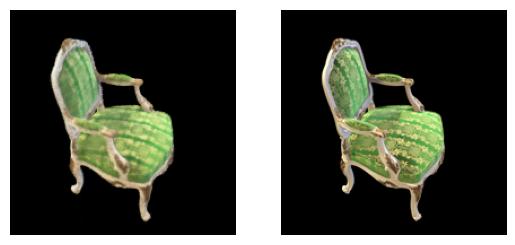

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (8/60) - loss : 0.0013406872607347807


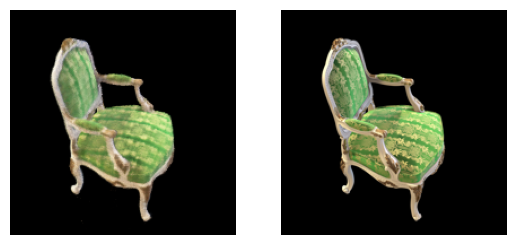

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (9/60) - loss : 0.0012305058691591513


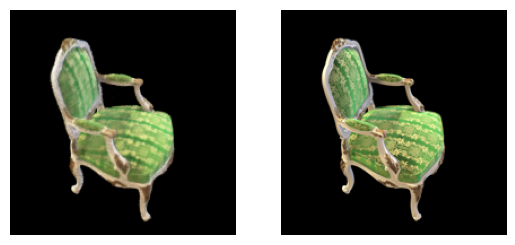

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (10/60) - loss : 0.0011509424903233863


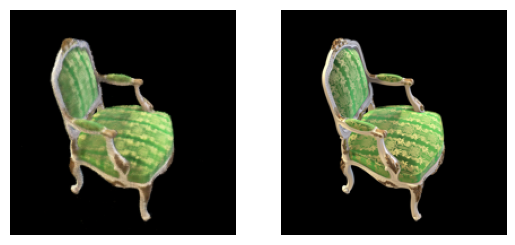

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (11/60) - loss : 0.001080808241216126


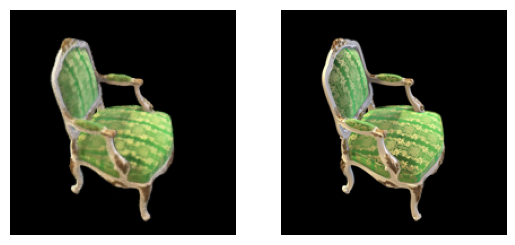

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (12/60) - loss : 0.001023053862249237


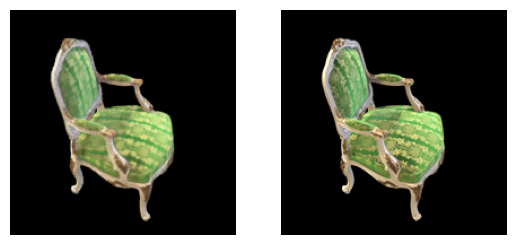

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (13/60) - loss : 0.0009694957118015379


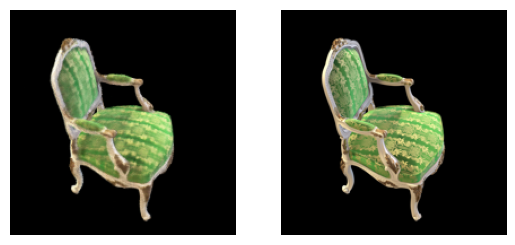

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (14/60) - loss : 0.0009264746859307597


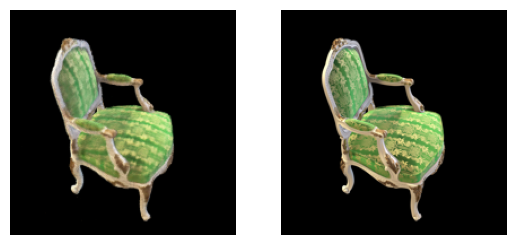

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (15/60) - loss : 0.0008854182273747091


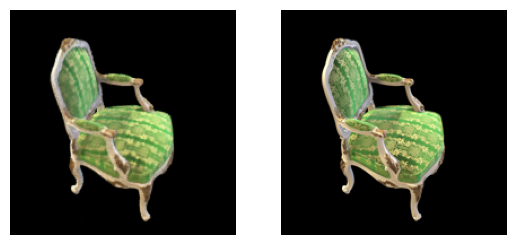

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (16/60) - loss : 0.0008500492261293732


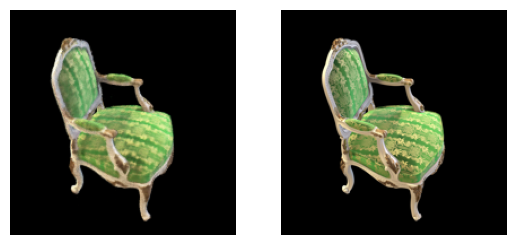

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (17/60) - loss : 0.0008176365264889023


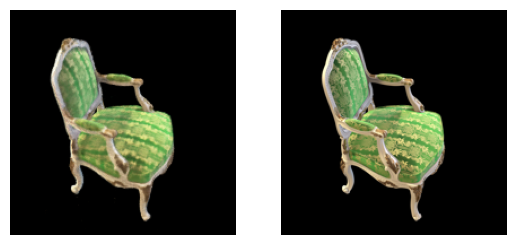

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (18/60) - loss : 0.0007905248325331924


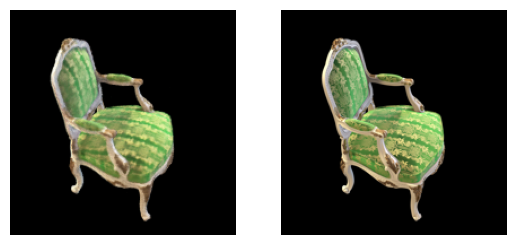

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (19/60) - loss : 0.0007642740003465113


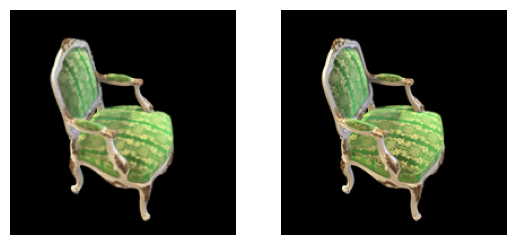

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (20/60) - loss : 0.0007407149538173242


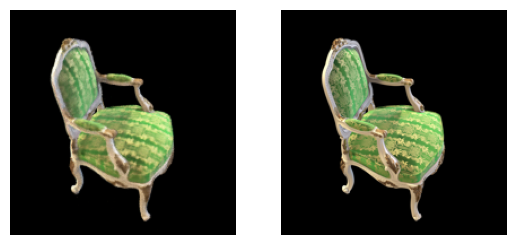

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (21/60) - loss : 0.0007179964751729587


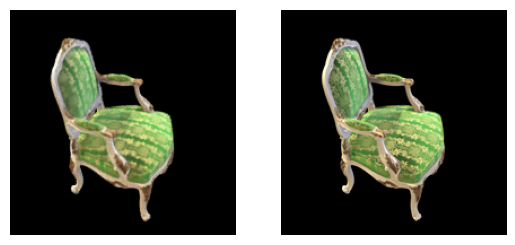

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (22/60) - loss : 0.0007001675321987637


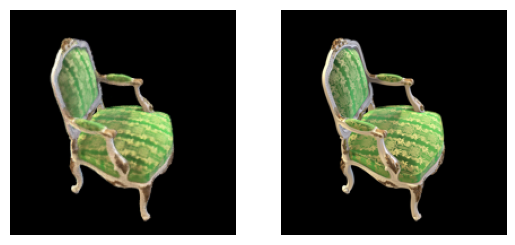

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (23/60) - loss : 0.0006797858034240905


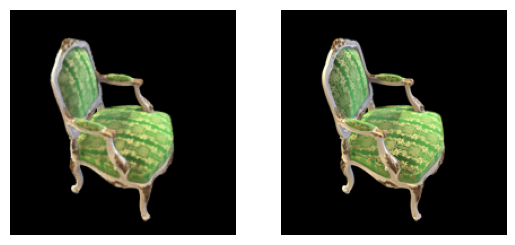

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (24/60) - loss : 0.0006611605965432723


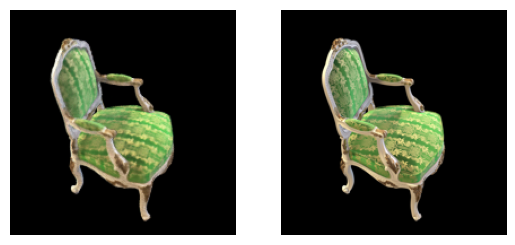

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (25/60) - loss : 0.0006465033959995551


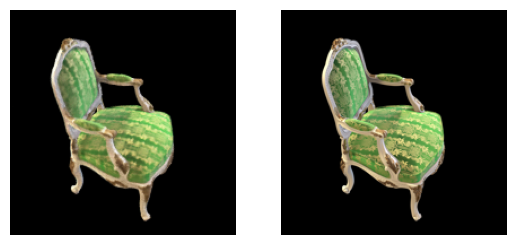

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (26/60) - loss : 0.00062972393899157


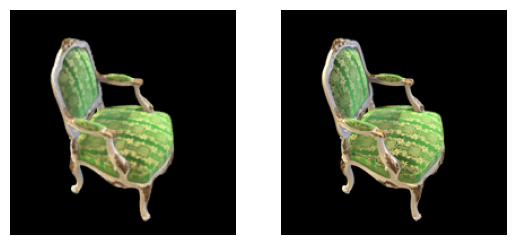

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (27/60) - loss : 0.0006141401383663962


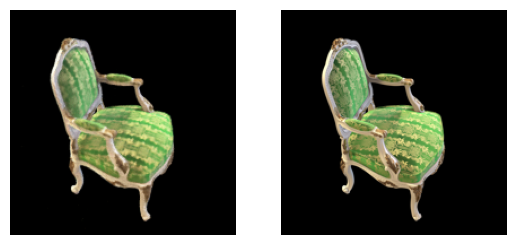

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (28/60) - loss : 0.0006007697564457494


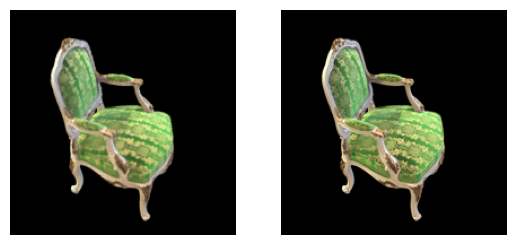

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (29/60) - loss : 0.0005886367420379992


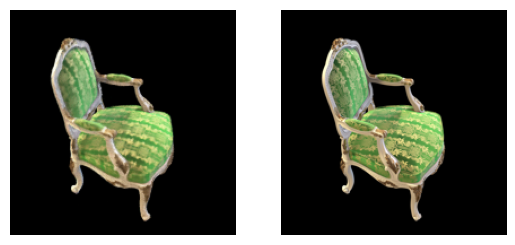

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (30/60) - loss : 0.0005756205886183819


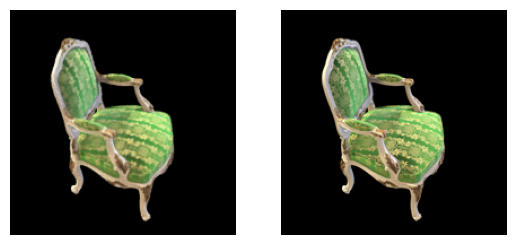

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (31/60) - loss : 0.0004954018503466718


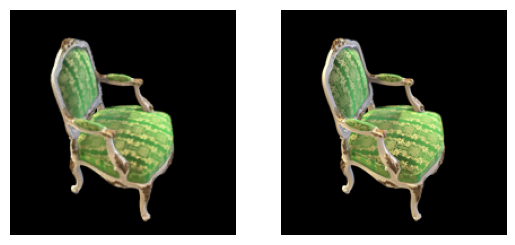

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (32/60) - loss : 0.00048397299050541065


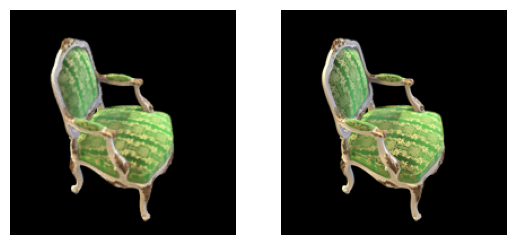

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (33/60) - loss : 0.0004764531519470056


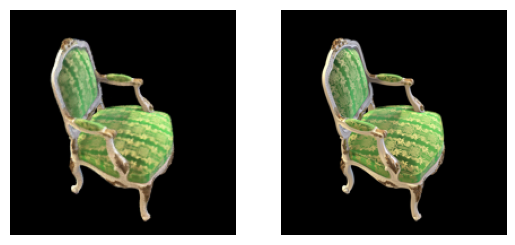

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (34/60) - loss : 0.00046962250356550754


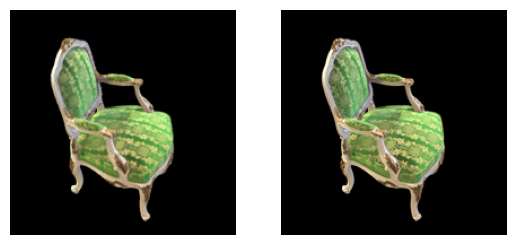

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (35/60) - loss : 0.00046259096883613277


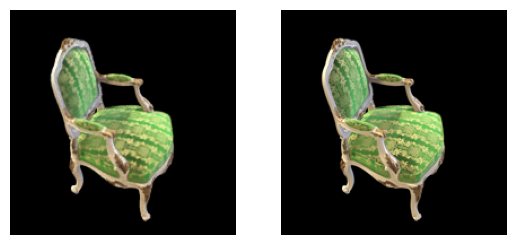

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (36/60) - loss : 0.00045611717514617455


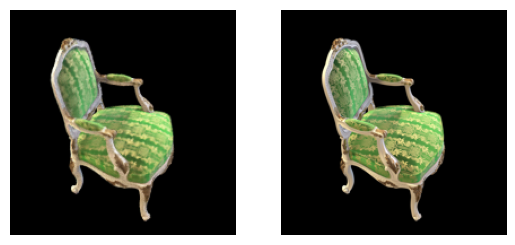

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (37/60) - loss : 0.0004508467585854099


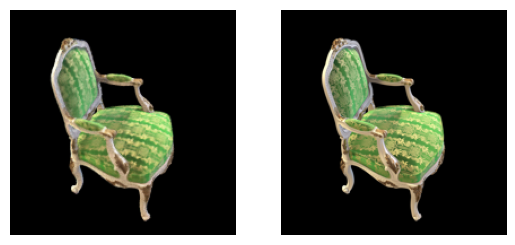

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (38/60) - loss : 0.00044528368354104824


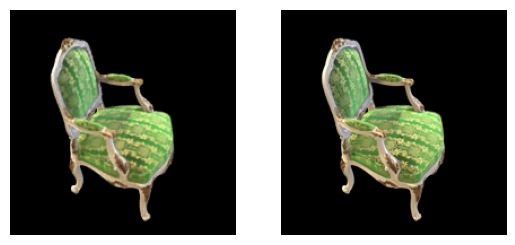

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (39/60) - loss : 0.0004400148744249906


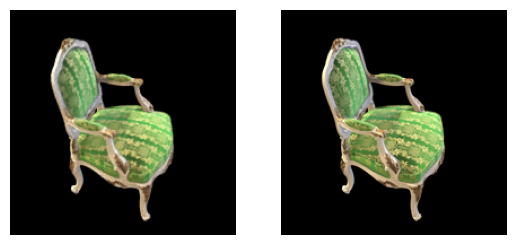

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (40/60) - loss : 0.0004347958886233536


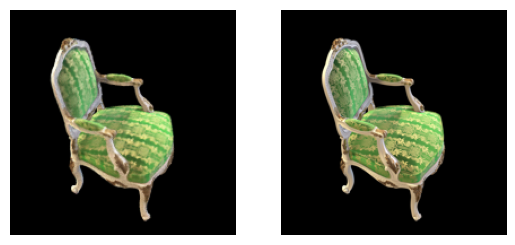

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (41/60) - loss : 0.0004299148905510464


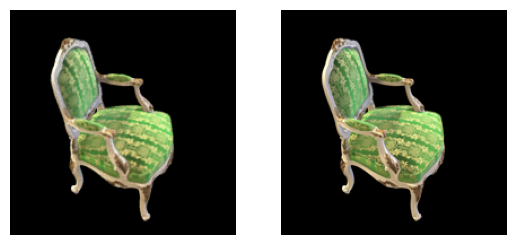

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (42/60) - loss : 0.0004250513504602307


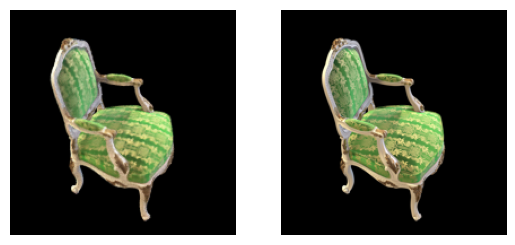

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (43/60) - loss : 0.00042097750827459733


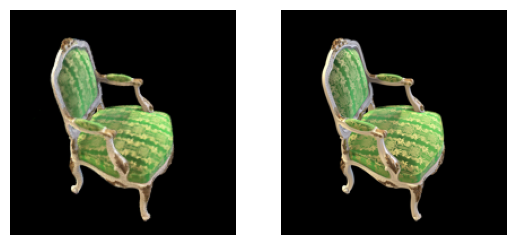

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (44/60) - loss : 0.0004159341227283593


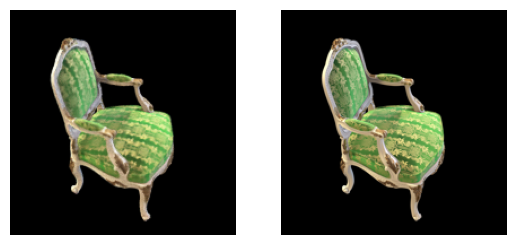

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (45/60) - loss : 0.00041138672452295565


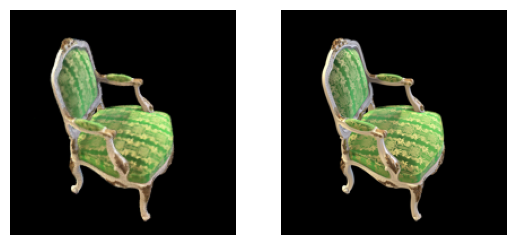

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (46/60) - loss : 0.00040630088245857524


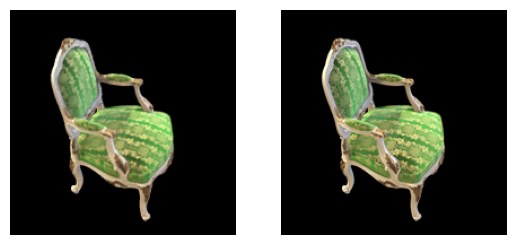

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (47/60) - loss : 0.00040256276197445686


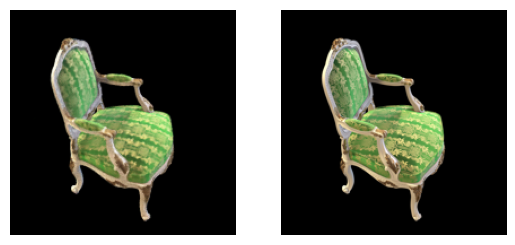

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (48/60) - loss : 0.0003995712899957768


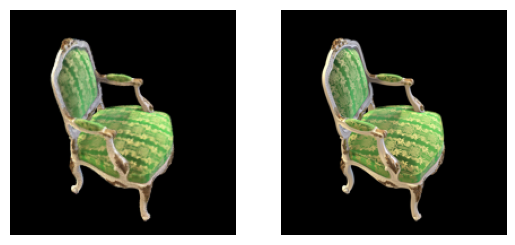

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (49/60) - loss : 0.00039493510386995237


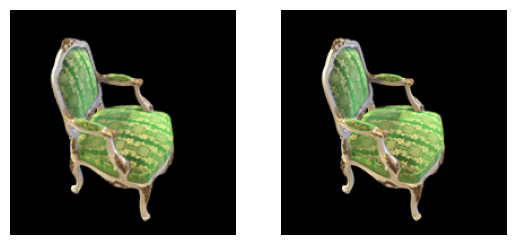

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (50/60) - loss : 0.00039148744711136203


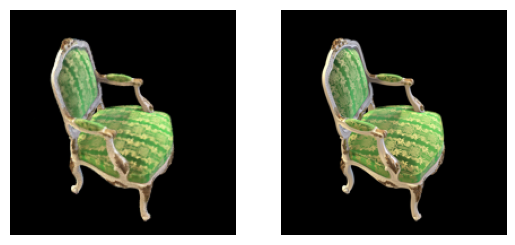

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (51/60) - loss : 0.0003882287984121198


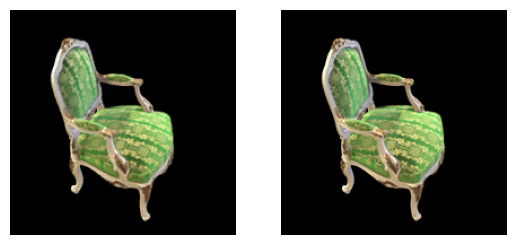

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (52/60) - loss : 0.0003850990370316905


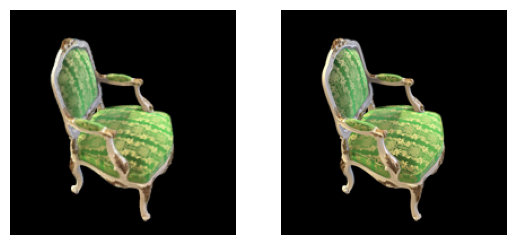

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (53/60) - loss : 0.0003800910136152961


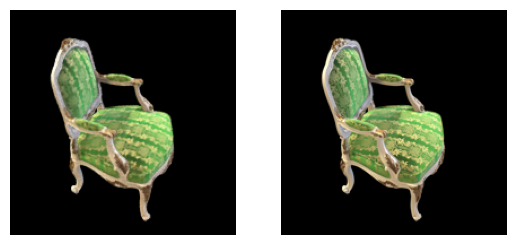

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (54/60) - loss : 0.00037736780598527476


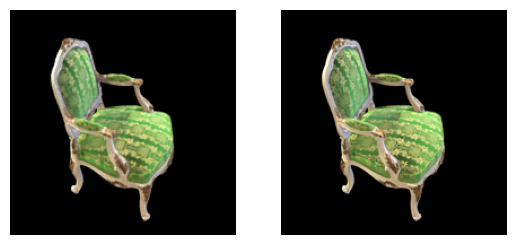

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (55/60) - loss : 0.00037511784208429314


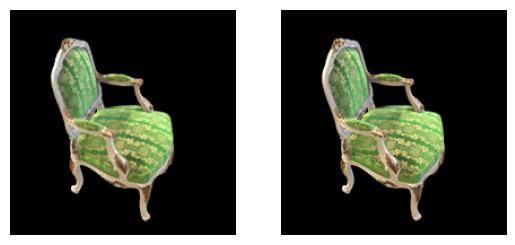

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (56/60) - loss : 0.0003705424959219204


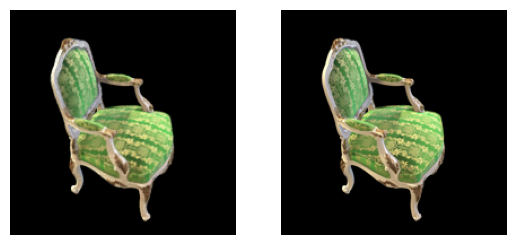

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (57/60) - loss : 0.0003677001273696815


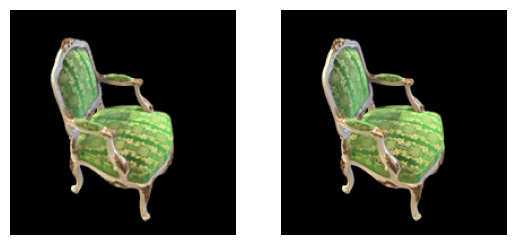

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (58/60) - loss : 0.0003652639001903358


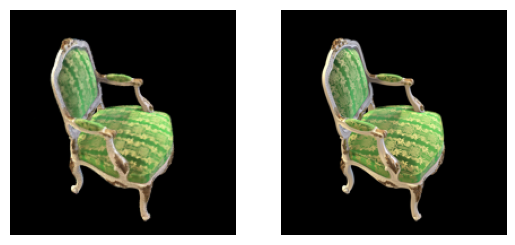

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (59/60) - loss : 0.0003613708855672819


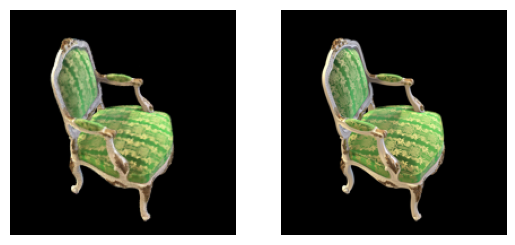

  0%|          | 0/3907 [00:00<?, ?it/s]

Epoch (60/60) - loss : 0.00035852716809309926


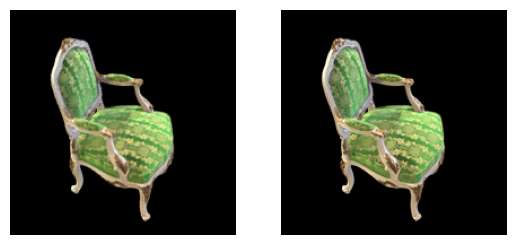

In [13]:
train_nerf_model(model, data_loader, losses, optimizer, scheduler, n_epochs, tn, tf, n_bins, test_rays_o[30].to(device), test_rays_d[30].to(device), plot_img=test_pixels[30].numpy().reshape(h, w, 3), device=device)

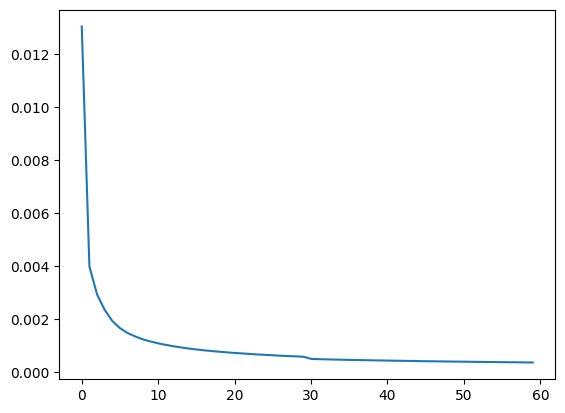

In [14]:
plt.plot(losses)
plt.show()

In [15]:
# load model
model = torch.load('./data/nerf_59.pt').to(device)
renderer = NeRFModelRenderer(model).to(device)

n_bins = 128
tn = 2.
tf = 6.

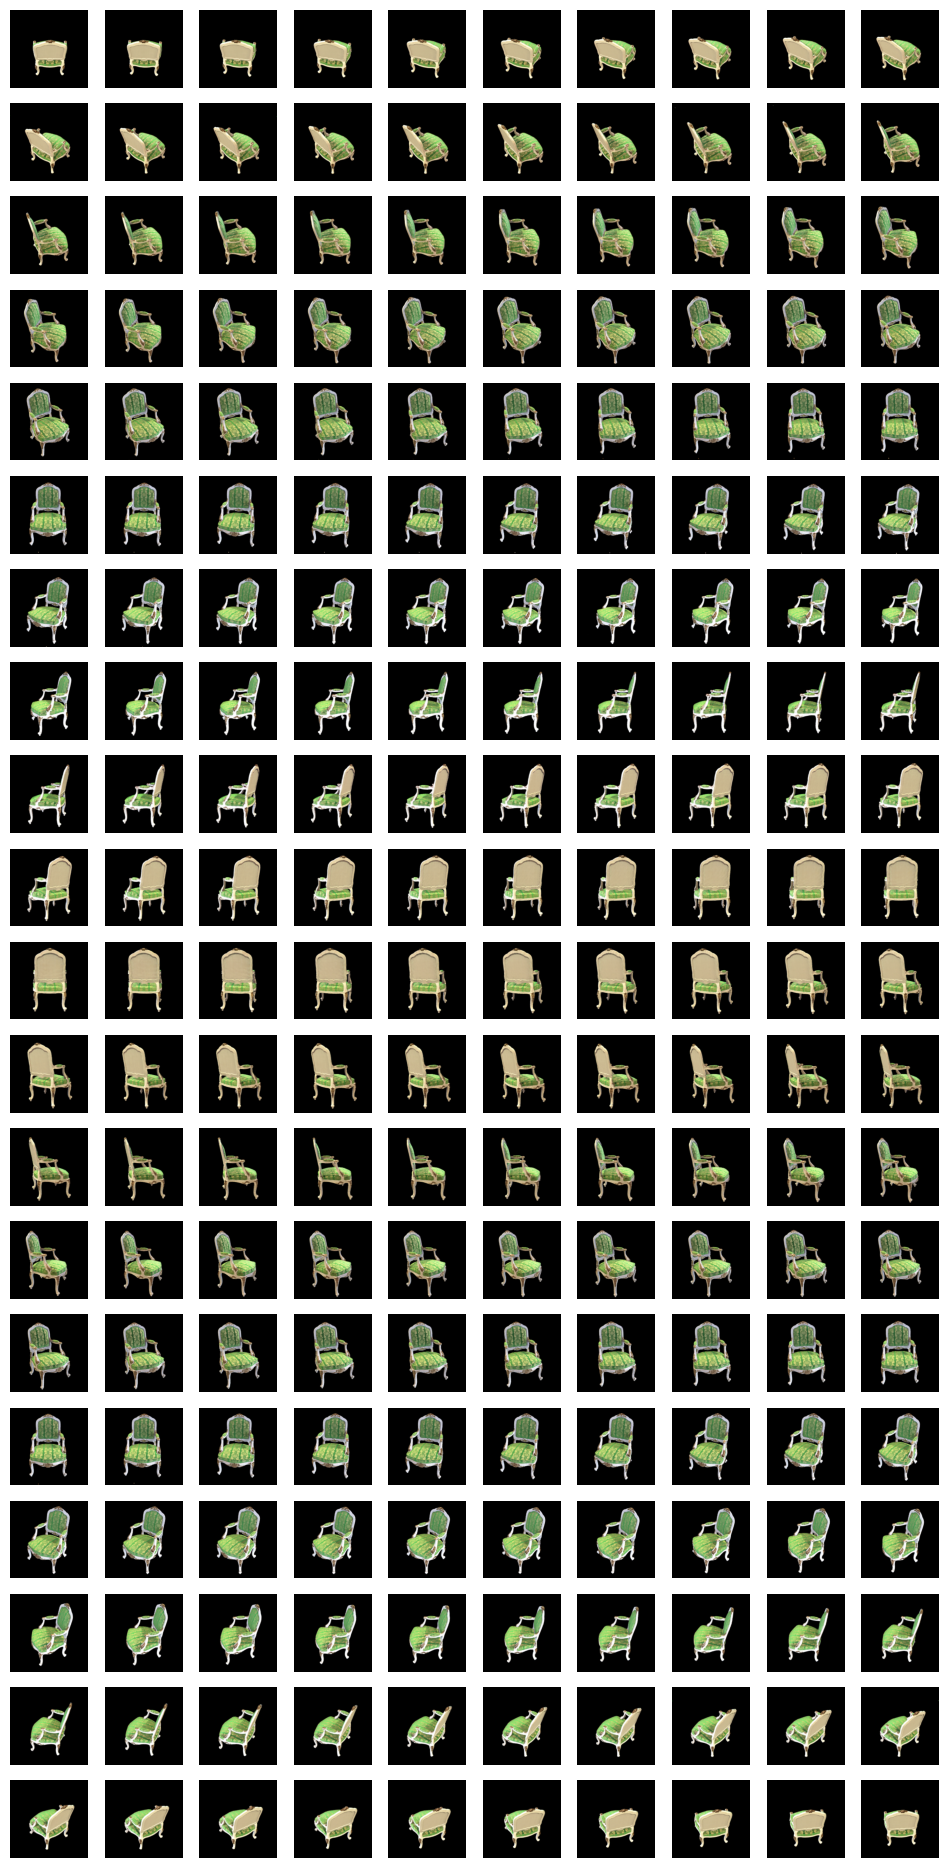

In [16]:
fig, axs = plt.subplots(nrows=20, ncols=10, figsize=(12, 24))

images = []
for i, ax in enumerate(axs.ravel()):
    result = batchify_rays(lambda ray_o, ray_d: renderer(ray_o, ray_d, tn, tf, n_bins, device), 4096, test_rays_o[i].to(device), test_rays_d[i].to(device)).reshape(h,w,3).numpy()
    ax.imshow(result)
    ax.axis('off')

    # into 0~255
    images.append((result*255).astype(np.uint8))
plt.show()

In [17]:
import imageio
imageio.mimsave('./img/out_nerf_chairs.gif', images)

In [7]:
# Test and get psnr

model = torch.load('./data/nerf_59.pt').to(device)
renderer = NeRFModelRenderer(model).to(device)

n_bins = 128
tn = 2.
tf = 6.


psnrs = []
for i in range(test_rays_o.shape[0]):
    result = batchify_rays(lambda ray_o, ray_d: renderer(ray_o, ray_d, tn, tf, n_bins, device), 4096, test_rays_o[i].to(device), test_rays_d[i].to(device))

    mse = ((result - test_pixels[i])**2).mean()
    psnr = 20*torch.log10(1./torch.sqrt(mse))
    psnrs.append(psnr.item())

In [11]:
print(f'the mean of psnr : {np.mean(psnrs):.4f}')

the mean of psnr : 32.3938
